# More Linear Regression!

### Encoding Categorical Variables, Incorporating Interaction and Polynomial Terms, Et Cetera


Today's focus is all about translating raw **data** into useful **information** that a model can understand and properly use. 

## But First - A Recap

In [25]:
# Imports
import pandas as pd
import numpy as np
# Setting random seed for reproducibility
np.random.seed(1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

New dataset for today! Insurance costs

My source: https://www.kaggle.com/mirichoi0218/insurance (they got the idea for cleaning up the original open source data from [Machine Learning with R](https://www.packtpub.com/product/machine-learning-with-r-third-edition/9781788295864))

In [69]:
df = pd.read_csv('data/insurance.csv')

In [70]:
# explore the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [72]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


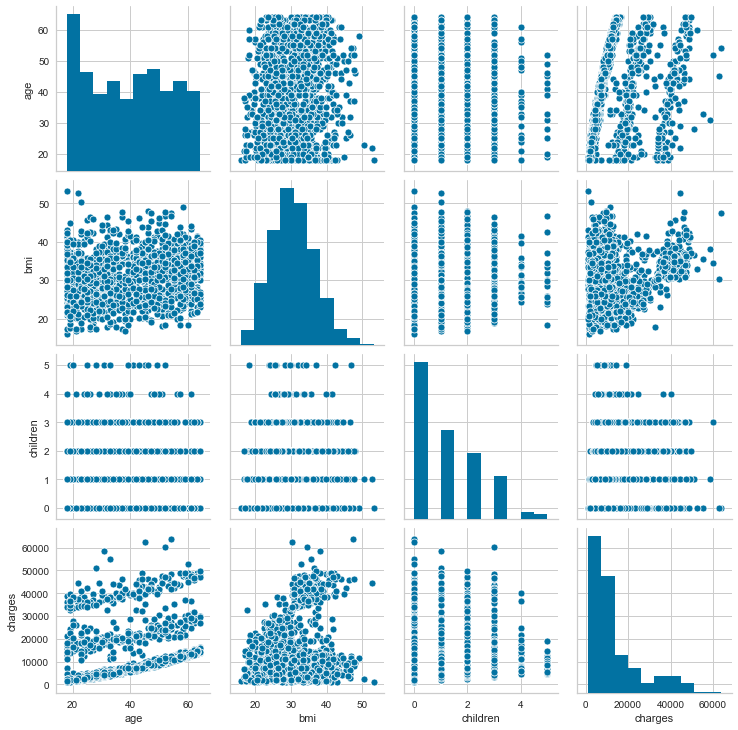

In [73]:
# visualize relationships between numeric columns
sns.pairplot(df)
plt.show()

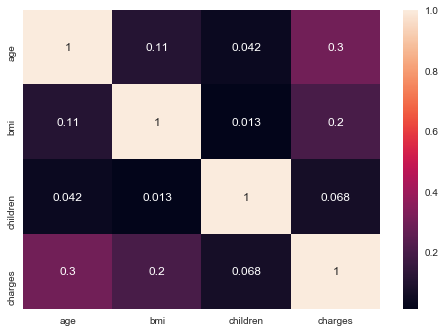

In [132]:
# visualize correlations between numeric columns
ax = sns.heatmap(df.corr(), annot=True)
# need to manually set my ylim because of my version of matplotlib
ax.set_ylim(4, 0)
plt.show()

In [75]:
# set our X and y
# ignore our categorical columns for now
used_cols = [c for c in df.columns.to_list() if c not in ['charges', 'sex', 'smoker', 'region']]
X = df[used_cols]
y = df['charges']

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [77]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train)

# transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
# now, let's model!
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [79]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_preds):.3f}")

Train R2 Score: 0.117
Test R2 Score: 0.127


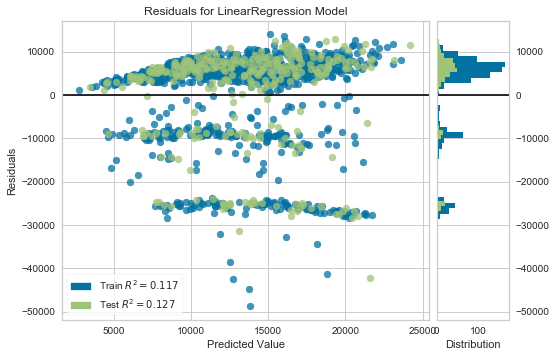

In [80]:
# visualizing our residuals
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

Ideas to continue improving this model?

- 


## Encoding Categorical Variables

How do we bring in those categorical columns? By **encoding** them - translating the string variables into useful numbers the model can hopefully understand and take meaning from.

### Most Common Encoding Method: One Hot Encoding (OHE)

Turns categorical columns into binaries, where each option is turned into its own column.

For our data: we have a column called `region`:

In [96]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [97]:
df['region'].head()

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object

With OHE, the result will either be three or four new columns: `is_southeast`, `is_northwest`, `is_southwest`, `is_northeast`

For the head of this data:

| `is_southeast` | `is_northwest` | `is_southwest` | `is_northeast` |
| -------------- | -------------- | -------------- | -------------- | 
| 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 0 |
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 1 | 0 | 0 |

Why could it be three? We often drop the first column, and allow the model to capture that value by having zeros in all other columns.

#### With Pandas' `get_dummies()`

In [81]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [82]:
cat_cols = ['sex', 'smoker', 'region']

In [83]:
x_cols = [*used_cols, *cat_cols]

In [84]:
x_cols

['age', 'bmi', 'children', 'sex', 'smoker', 'region']

In [85]:
# one hot encode variables
df_ohe = pd.get_dummies(df[x_cols],
                        columns=cat_cols,
                        drop_first=True)
print(df_ohe.shape)
df_ohe.head()

(1338, 8)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


#### With `sklearn`'s One Hot Encoder

In [86]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [87]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(df[x_cols])
X = ct.transform(df[x_cols])

In [88]:
type(X)

numpy.ndarray

In [89]:
# can display as a dataframe like so
pd.DataFrame(X, columns= ct.get_feature_names()).head()

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.0,1.0,0.0,0.0,1.0,19.0,27.900,0.0
1,1.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0
2,1.0,0.0,0.0,1.0,0.0,28.0,33.000,3.0
3,1.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0
4,1.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [91]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train)

# transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
# now, let's model!
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [93]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_preds):.3f}")

Train R2 Score: 0.745
Test R2 Score: 0.767


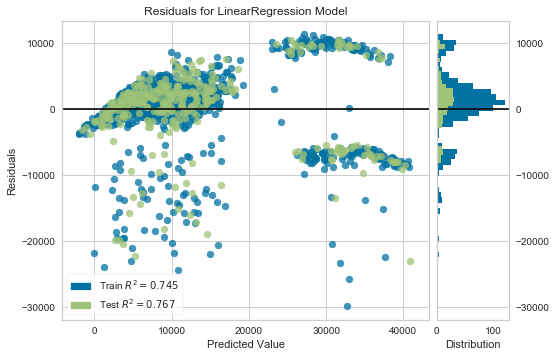

In [94]:
# visualizing our residuals
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

#### Some Pros and Cons of OHE:

Pros:

- Simple to understand
- Easy to implement

Cons:

- If the categorical column has many options, or there are a lot of categorical columns, you can add _a lot_ more columns - **curse of dimensionality**
- Resulting columns are very sparse (mostly zeros)
- Resulting columns are directly related (multicollinear)

### Other Encoding Methods?

Certainly there are other ways to turn a categorical column into numeric data that a model can understand.

Some Examples:

- [Label/Ordinal Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
- [Frequency Encoding](https://contrib.scikit-learn.org/category_encoders/count.html) (just a count encoder with `normalize=True` to turn into a frequency percentage)
- [Target Encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) (or, relatedly, [Leave-One-Out Encoding](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html) or [Weight of Evidence Encoding](https://contrib.scikit-learn.org/category_encoders/woe.html))

Useful links:

- [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) - library of sklearn-style encoders that implement more encoding methods than those actually packaged in Sklearn
- [Sklearn's Preprocessing Section](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) - user guide section on preprocessing (includes scalers and transformers as well as encoders)

## Polynomial Terms - Simple Linear Regression

Demonstrating this on a toy example, with a single x variable predicting y.

In [117]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

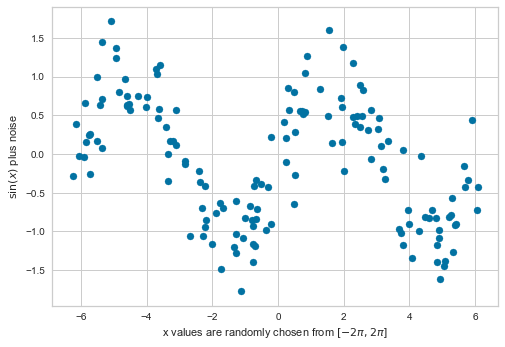

In [118]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$ plus noise')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()

In [119]:
# Fitting a linear model
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression()

In [120]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [121]:
# Scoring our model
print(f"R2 Score: {r2_score(y, y_pred)}")

R2 Score: 0.13519811764759415


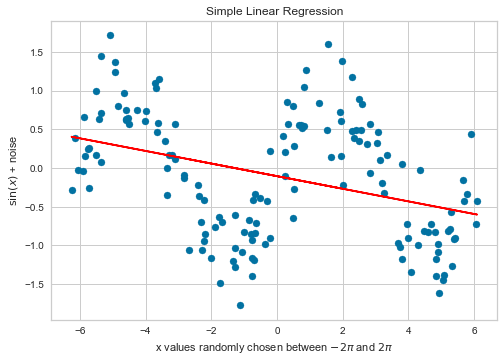

In [122]:
# Visualize it
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Simple Linear Regression")

plt.show()

Is this a good model? Well - of course not. It's definitely **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [123]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [-0.0994]
R-Squared: 0.000


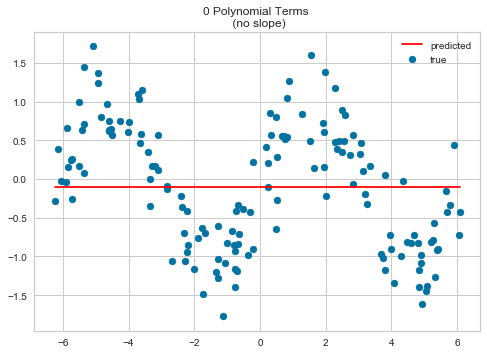

-------------
Coefficients:  [-0.1054 -0.0814]
R-Squared: 0.135


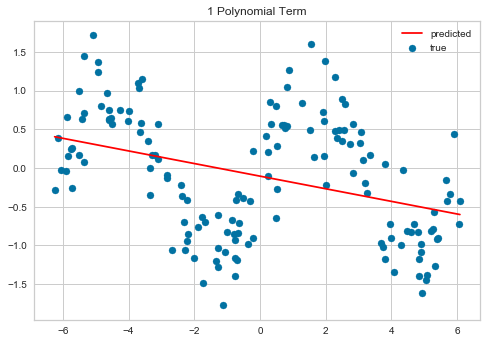

-------------
Coefficients:  [-0.1265 -0.0811  0.0016]
R-Squared: 0.136


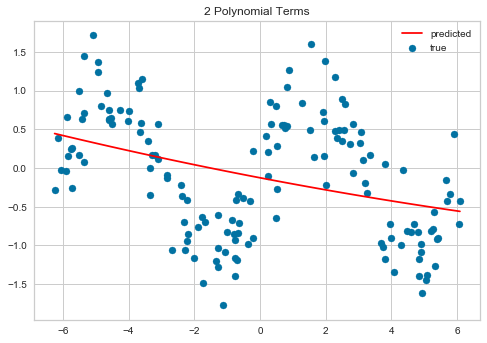

-------------
Coefficients:  [-0.103   0.0832 -0.0008 -0.007 ]
R-Squared: 0.232


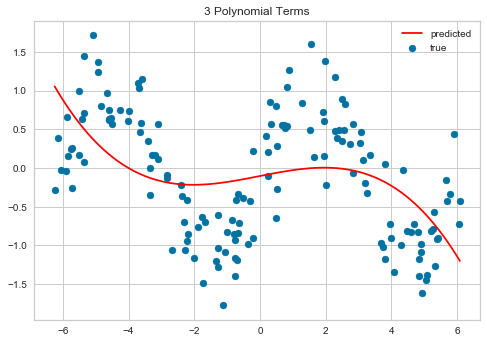

-------------
Coefficients:  [-0.1513  0.6129  0.0149 -0.0714 -0.0003  0.0015]
R-Squared: 0.687


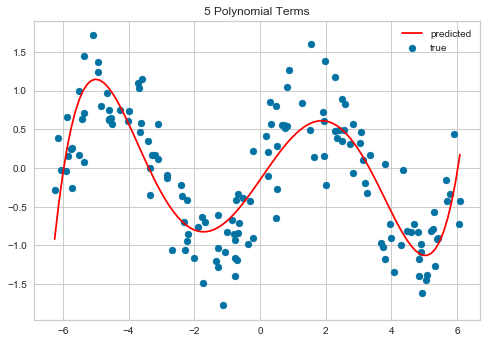

-------------
Coefficients:  [-0.1646  0.9111  0.0319 -0.1402 -0.0017  0.0054  0.     -0.0001]
R-Squared: 0.761


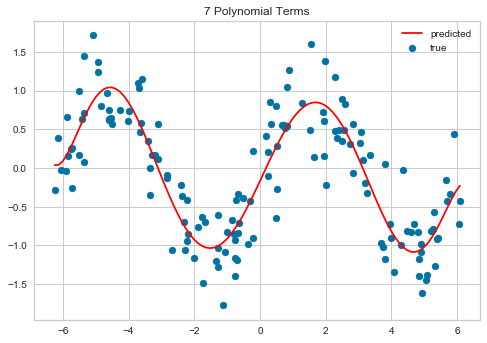

-------------
Coefficients:  [-0.1716  0.9651  0.0424 -0.1604 -0.0032  0.0074  0.0001 -0.0001 -0.
  0.    ]
R-Squared: 0.763


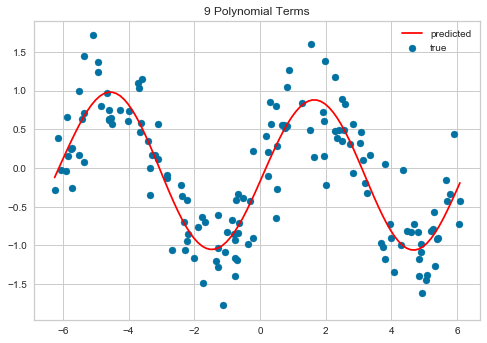

-------------
Coefficients:  [-0.12    1.0427 -0.031  -0.195   0.0133  0.0103 -0.0011 -0.      0.
 -0.     -0.      0.     -0.     -0.    ]
R-Squared: 0.775


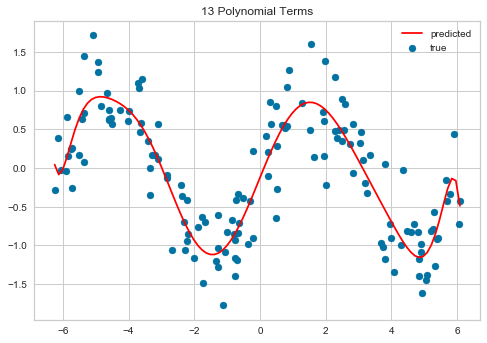

-------------
Coefficients:  [-0.1118  1.2978 -0.0199 -0.5794 -0.0209  0.1608  0.0122 -0.0258 -0.0021
  0.0023  0.0002 -0.0001 -0.      0.      0.     -0.     -0.      0.
  0.    ]
R-Squared: 0.795


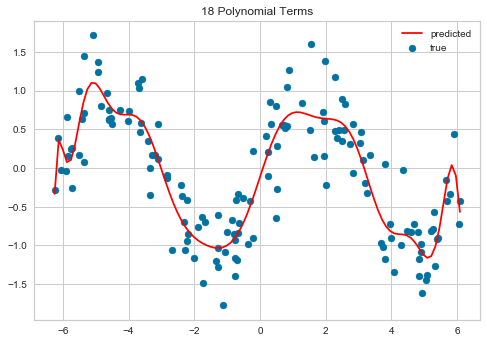

In [124]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

Evaluate: which of these is the best?

- 


Evaluate: so what?

- 


## Interaction Terms

When do we need interaction terms? And how do we check for them?

Well, first things first - what interactions do _you_ think would make sense? That's the easiest way to incorporate interaction terms - use domain knowledge to think through what usefully could be combined into an interaction.

As for how to check if something might be better captured as an interaction...

In [196]:
# add the target back onto our OHE df
df_ohe['target'] = df['charges']

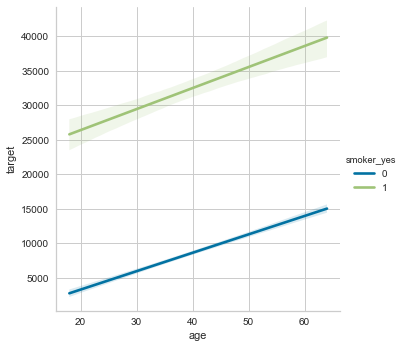

In [197]:
# an example of no interaction term...
sns.lmplot(x='age', y='target', hue='smoker_yes', data=df_ohe, scatter=False)
plt.show()

How do I know these two variables, `age` and `smoker_yes`, aren't interacting? 

- Look at the slopes - parallel


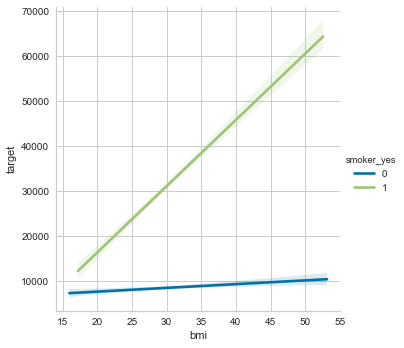

In [198]:
# now let's look at something else...
sns.lmplot(x='bmi', y='target', hue='smoker_yes', data=df_ohe, scatter=False)
plt.show()

What do you think?

- 


## Implementing Interaction and Polynomials in Sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [199]:
from sklearn.preprocessing import PolynomialFeatures

In [204]:
X = df_ohe.drop(columns = 'target')
y = df_ohe['target']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

Let's first do Polynomials, to the 3rd degree:

In [200]:
poly = PolynomialFeatures(degree=3, interaction_only=False)

In [207]:
poly.fit(X_train)

PolynomialFeatures(degree=3)

In [208]:
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [213]:
X_train_poly = pd.DataFrame(X_train_poly, columns = poly.get_feature_names())
X_train_poly.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0^2,...,x5^3,x5^2 x6,x5^2 x7,x5 x6^2,x5 x6 x7,x5 x7^2,x6^3,x6^2 x7,x6 x7^2,x7^3
0,1.0,24.0,23.655,0.0,1.0,0.0,1.0,0.0,0.0,576.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,28.0,26.510,2.0,0.0,0.0,0.0,1.0,0.0,784.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,51.0,39.700,1.0,1.0,0.0,0.0,0.0,1.0,2601.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,47.0,36.080,1.0,1.0,1.0,0.0,1.0,0.0,2209.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,46.0,28.900,2.0,0.0,0.0,0.0,0.0,1.0,2116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [214]:
X_train_poly.columns

Index(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x0^2',
       ...
       'x5^3', 'x5^2 x6', 'x5^2 x7', 'x5 x6^2', 'x5 x6 x7', 'x5 x7^2', 'x6^3',
       'x6^2 x7', 'x6 x7^2', 'x7^3'],
      dtype='object', length=165)

In [215]:
X_train_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Columns: 165 entries, 1 to x7^3
dtypes: float64(165)
memory usage: 1.3 MB


In [221]:
# Still need to scale
scaler = StandardScaler()

scaler.fit(X_train_poly)

X_train_poly_sc = scaler.transform(X_train_poly)
X_test_poly_sc = scaler.transform(X_test_poly)

In [224]:
lr = LinearRegression()

lr.fit(X_train_poly_sc, y_train)

X_train_poly_preds = lr.predict(X_train_poly_sc)
X_test_poly_preds = lr.predict(X_test_poly_sc)

In [226]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, X_train_poly_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, X_test_poly_preds):.3f}")

Train R2 Score: 0.857
Test R2 Score: 0.839


----

In [216]:
interactions = PolynomialFeatures(degree=2, interaction_only=True)

interactions.fit(X_train)

PolynomialFeatures(interaction_only=True)

In [217]:
X_train_ints = interactions.transform(X_train)
X_test_ints = interactions.transform(X_test)

In [218]:
X_train_ints = pd.DataFrame(X_train_ints, columns = interactions.get_feature_names())
X_train_ints.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x0 x1,...,x3 x4,x3 x5,x3 x6,x3 x7,x4 x5,x4 x6,x4 x7,x5 x6,x5 x7,x6 x7
0,1.0,24.0,23.655,0.0,1.0,0.0,1.0,0.0,0.0,567.72,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,28.0,26.510,2.0,0.0,0.0,0.0,1.0,0.0,742.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,51.0,39.700,1.0,1.0,0.0,0.0,0.0,1.0,2024.70,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,47.0,36.080,1.0,1.0,1.0,0.0,1.0,0.0,1695.76,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,46.0,28.900,2.0,0.0,0.0,0.0,0.0,1.0,1329.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
# Still need to scale
scaler = StandardScaler()

scaler.fit(X_train_ints)

X_train_ints_sc = scaler.transform(X_train_ints)
X_test_ints_sc = scaler.transform(X_test_ints)

In [228]:
lr = LinearRegression()

lr.fit(X_train_ints_sc, y_train)

X_train_ints_preds = lr.predict(X_train_ints_sc)
X_test_ints_preds = lr.predict(X_test_ints_sc)

In [229]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, X_train_ints_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, X_test_ints_preds):.3f}")

Train R2 Score: 0.841
Test R2 Score: 0.851


Evaluate: What do you think? Is this blanket way of approaching polynomial or interaction terms useful?

- 


## Feature Selection and Feature Importances...

Not much time to do this, but:

- Lasso Regression (L1 regularization)
- Recursive Feature Elimination
- Forward Stepwise Selection

Can always check out the python library [`eli5`](https://eli5.readthedocs.io/en/latest/index.html) (yes, Explain Like I'm 5)

## Resources:

[Feature Engineering and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) (computing done in R, but book focuses mostly on discussing the hows and whys rather than focusing on implementation)

- Their chapter on [Encoding Categorical Predictors](https://bookdown.org/max/FES/encoding-categorical-predictors.html)
- And their chapter on [Detecting Interaction Effects](https://bookdown.org/max/FES/detecting-interaction-effects.html)